kernel_ode test

In [1]:
%matplotlib notebook
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import cmath
import scipy.special

In [2]:
# Change parameter here
# Data synthesis settings
batch = 100
tmax = 30
tmax1 = 50
px = 40
py = 40
r = 3
vid_lt = 50

Kernel function with 2nd order ode

In [3]:
def kernel_ode(X,Y,l=1,freq=0.6,damping=0.05):

    def hfcn(l,gamma_q,gamma_p,t,tp):
        out=(gfcn(l,gamma_q,tp,t)-cmath.exp(-gamma_p*t)*gfcn(l,gamma_q,tp,0))/(gamma_q+gamma_p)
        return out

    def gfcn(l,gamma_q,t,tp):
        out=2*cmath.exp(l**2*gamma_q**2/4)*cmath.exp(-gamma_q*(t-tp))-cmath.exp(-(t-tp)**2/l**2)*scipy.special.wofz(1j*zfcn(l,t,tp,gamma_q))-cmath.exp(-tp**2/l**2)*cmath.exp(-gamma_q*t)*scipy.special.wofz(-1j*zfcn(l,0,tp,gamma_q))
        return out

    def zfcn(l,t,tp,gamma_q):
        out=(t-tp)/l-(l*gamma_q)/2
        return out
    
    d_ode=freq**2
    c_ode=2*damping*freq
    alpha=c_ode/2
    w=np.sqrt(4*d_ode-c_ode**2)/2
    
    length_X=np.size(X)
    length_Y=np.size(Y)
    
    Sigma=np.zeros([length_X, length_Y])

    for i in range(length_X):
        for k in range(length_Y):
            t=X[i]
            tp=Y[k]
            gamma=alpha+1j*w
            gamma_t=alpha-1j*w
            Sigma[i,k]=(np.sqrt(np.pi*l**2)/8/w**2*(hfcn(l,gamma_t,gamma,t,tp)+hfcn(l,gamma,gamma_t,tp,t)+hfcn(l,gamma,gamma_t,t,tp)+hfcn(l,gamma_t,gamma,tp,t)-hfcn(l,gamma_t,gamma_t,t,tp)-hfcn(l,gamma_t,gamma_t,tp,t)-hfcn(l,gamma,gamma,t,tp)-hfcn(l,gamma,gamma,tp,t))).real 
    
    return Sigma

Function to create video based on trajectories

In [4]:
def Make_Video_batch(tmax=50, tmax1=50, px=32, py=32, lt=5, batch=40, seed=1, r=3):
    """
    params:
        tmax: number of frames to generate
        px: horizontal resolution
        py: vertical resolution
        lt: length scale
        batch: number of videos
        seed: rng seed
        r: radius of ball in pixels
    
    returns:
        traj0: (batch, tmax, 2) numpy array
        vid_batch: (batch, tmax, px, py) numpy array
    """

    def pixelate_frame(xy):
        """
        takes a single x,y pixel point and converts to binary image
        with ball centered at x,y.
        """
        x = xy[0]
        y = xy[1]

        sq_x = (np.arange(px) - x)**2
        sq_y = (np.arange(py) - y)**2

        sq = sq_x.reshape(1,-1) + sq_y.reshape(-1,1)

        image = 1*(sq < rr)

        return image

    
    def pixelate_series(XY):
        vid = map(pixelate_frame, XY)
        vid = [v for v in vid]
        return np.asarray(vid)
    
    rr = r*r
    traj0_normal, traj0_sparse, traj0_extrapolate = Make_path_batch(batch=batch, tmax=tmax, tmax1=tmax1, lt=lt)

    traj_normal = traj0_normal.copy()
    traj_sparse = traj0_sparse.copy()
    traj_extrapolate = traj0_extrapolate.copy()

    # convert trajectories to pixel dims
    #max_normal_x=px/2/np.max(np.abs(traj_normal[:,:,0]))
    #max_normal_y=py/2/np.max(np.abs(traj_normal[:,:,1]))
    #max_sparse_x=px/2/np.max(np.abs(traj_sparse[:,:,0]))
    #max_sparse_y=py/2/np.max(np.abs(traj_sparse[:,:,1]))
    #max_extrapolate_x=px/2/np.max(np.abs(traj_extrapolate[:,:,0]))
    #max_extrapolate_y=py/2/np.max(np.abs(traj_extrapolate[:,:,1]))
    #for i in range(batch):
    #    traj_normal[i,:,0] = px/2/np.max(np.abs(traj_normal[i,:,0]))*traj_normal[i,:,0]+px/2
    #    traj_normal[i,:,1] = py/2/np.max(np.abs(traj_normal[i,:,1]))*traj_normal[i,:,1]+py/2
    #    traj_sparse[i,:,0] = px/2/np.max(np.abs(traj_sparse[i,:,0]))*traj_sparse[i,:,0]+px/2
    #    traj_sparse[i,:,1] = py/2/np.max(np.abs(traj_sparse[i,:,1]))*traj_sparse[i,:,1]+py/2
    #    traj_extrapolate[i,:,0] = px/2/np.max(np.abs(traj_extrapolate[i,:,0]))*traj_extrapolate[i,:,0]+px/2
    #    traj_extrapolate[i,:,1] = py/2/np.max(np.abs(traj_extrapolate[i,:,1]))*traj_extrapolate[i,:,1]+py/2
    
    traj_normal[:,:,0] = traj_normal[:,:,0] * (px/5) + (0.5*px)
    traj_normal[:,:,1] = traj_normal[:,:,1] * (py/5) + (0.5*py)
    traj_sparse[:,:,0] = traj_sparse[:,:,0] * (px/5) + (0.5*px)
    traj_sparse[:,:,1] = traj_sparse[:,:,1] * (py/5) + (0.5*py)    
    traj_extrapolate[:,:,0] = traj_extrapolate[:,:,0] * (px/5) + (0.5*px)
    traj_extrapolate[:,:,1] = traj_extrapolate[:,:,1] * (py/5) + (0.5*py)
     
    print(np.max(traj_normal[:,:,0]))
    print(np.min(traj_normal[:,:,0]))
    print(np.max(traj_normal[:,:,1]))
    print(np.min(traj_normal[:,:,1]))
    vid_batch_normal = [pixelate_series(traj_i) for traj_i in traj_normal]
    vid_batch_normal = np.asarray(vid_batch_normal)
    vid_batch_sparse = [pixelate_series(traj_i) for traj_i in traj_sparse]
    vid_batch_sparse = np.asarray(vid_batch_sparse)
    vid_batch_extrapolate = [pixelate_series(traj_i) for traj_i in traj_extrapolate]
    vid_batch_extrapolate = np.asarray(vid_batch_extrapolate)

    return traj0_normal, vid_batch_normal, traj0_sparse, vid_batch_sparse, traj0_extrapolate, vid_batch_extrapolate

Function to create trajectories by drawing samples from GP with ode prior knowledge encoded in the kernel function

In [5]:
def Make_path_batch(batch=40,tmax=30,tmax1=30, lt=5,seed=None):
    """
    Samples x(t), y(t) from a GP
    args:
        batch: number of samples
        tmax: length of samples
        lt: GP length scale
    returns:
        traj: nparray (batch, tmax, 2)
    """

    T = np.arange(tmax1)
    Mu = np.zeros(np.size(T))
    Sigma_x=0.02*kernel_ode(T,T,l=lt,freq=0.3,damping=0.02) 
    Sigma_y=0.02*kernel_ode(T,T,l=lt,freq=0.4,damping=0.01)
    traj = np.zeros((batch, 2, tmax1))
    
    Sigma_x=Sigma_x #CHANGE +0.000001*np.eye(tmax1)
    Sigma_y=Sigma_y #CHANGE +0.000001*np.eye(tmax1)
    np.random.seed(seed)
    traj[:,0,:] = np.random.multivariate_normal(Mu, Sigma_x, batch)
    traj[:,1,:] = np.random.multivariate_normal(Mu, Sigma_y, batch)

    traj = np.transpose(traj, (0,2,1))

    traj_normal = traj[:, :tmax].copy()
    traj_sparse = traj[:, list(range(0, tmax, 2))].copy()
    traj_extrapolate = traj.copy()

    return traj_normal, traj_sparse, traj_extrapolate

In [6]:
traj0_normal, vid_batch_normal, traj0_sparse, vid_batch_sparse, traj0_extrapolate, vid_batch_extrapolate = Make_Video_batch(tmax=tmax, tmax1=tmax1, px=px, py=py, lt=vid_lt, batch=batch, r=r)

Test_Batches = [(traj0_normal, vid_batch_normal)]
with open("./Test_Batches.pkl", "wb") as f:
    pickle.dump(Test_Batches, f)

Test_Batches = [(traj0_sparse, vid_batch_sparse)]
with open("./Test_Batches_sparse.pkl", "wb") as f:
    pickle.dump(Test_Batches, f)

Test_Batches = [(traj0_extrapolate, vid_batch_extrapolate)]
with open("./Test_Batches_extrapolate.pkl", "wb") as f:
    pickle.dump(Test_Batches, f)

69.06692855833168
-23.408982522705465
53.964063041513754
-6.814041816493489


<IPython.core.display.Javascript object>


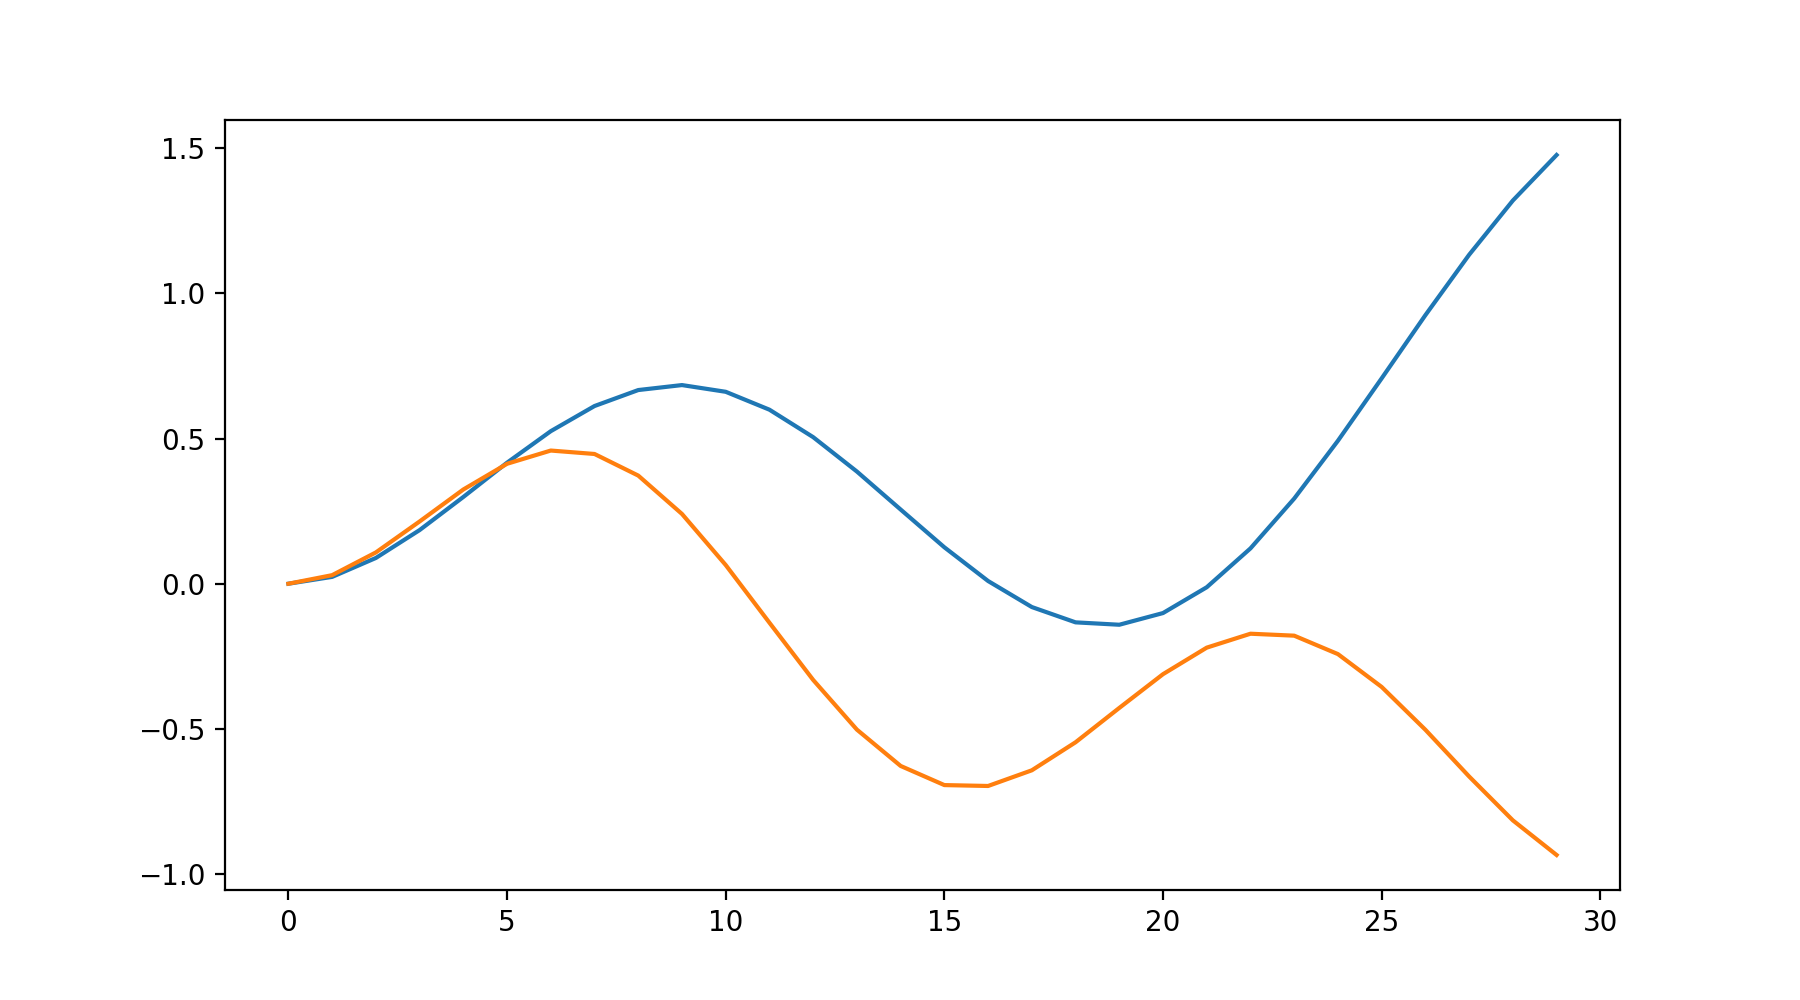

In [7]:
tmax = len(traj0_normal[0])
T = np.arange(tmax)
plt.figure(figsize=(9,5))
plt.plot(T,traj0_normal[0,:,:])
plt.show()

<IPython.core.display.Javascript object>


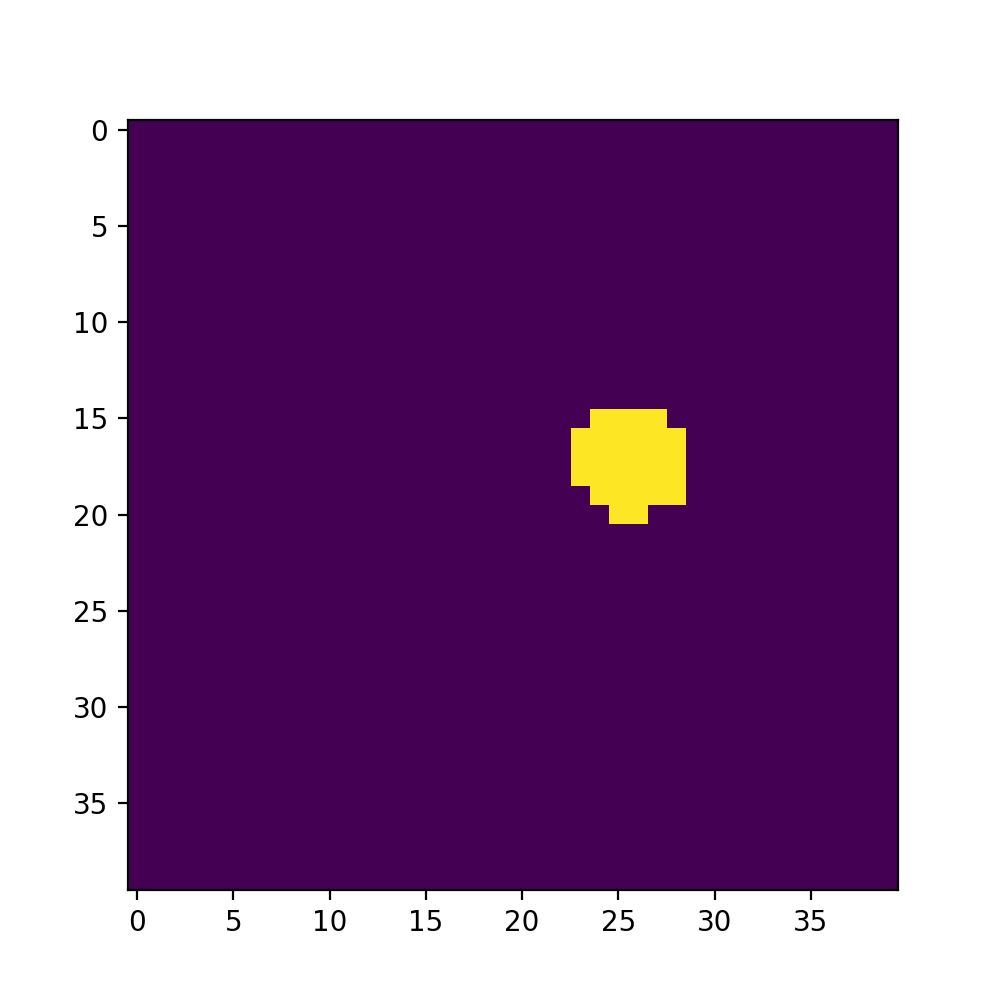

In [8]:
fig = plt.figure(figsize=(5,5))
img = plt.imshow(vid_batch_normal[0,0,:,:], animated=True)
batch_nr = 0

def animate(frame_num):
    img.set_array(vid_batch_normal[batch_nr,frame_num,:,:])
    print(frame_num)
    return img
    
anim = FuncAnimation(fig, animate, frames=vid_batch_normal.shape[1], interval=100)
plt.show()

<IPython.core.display.Javascript object>


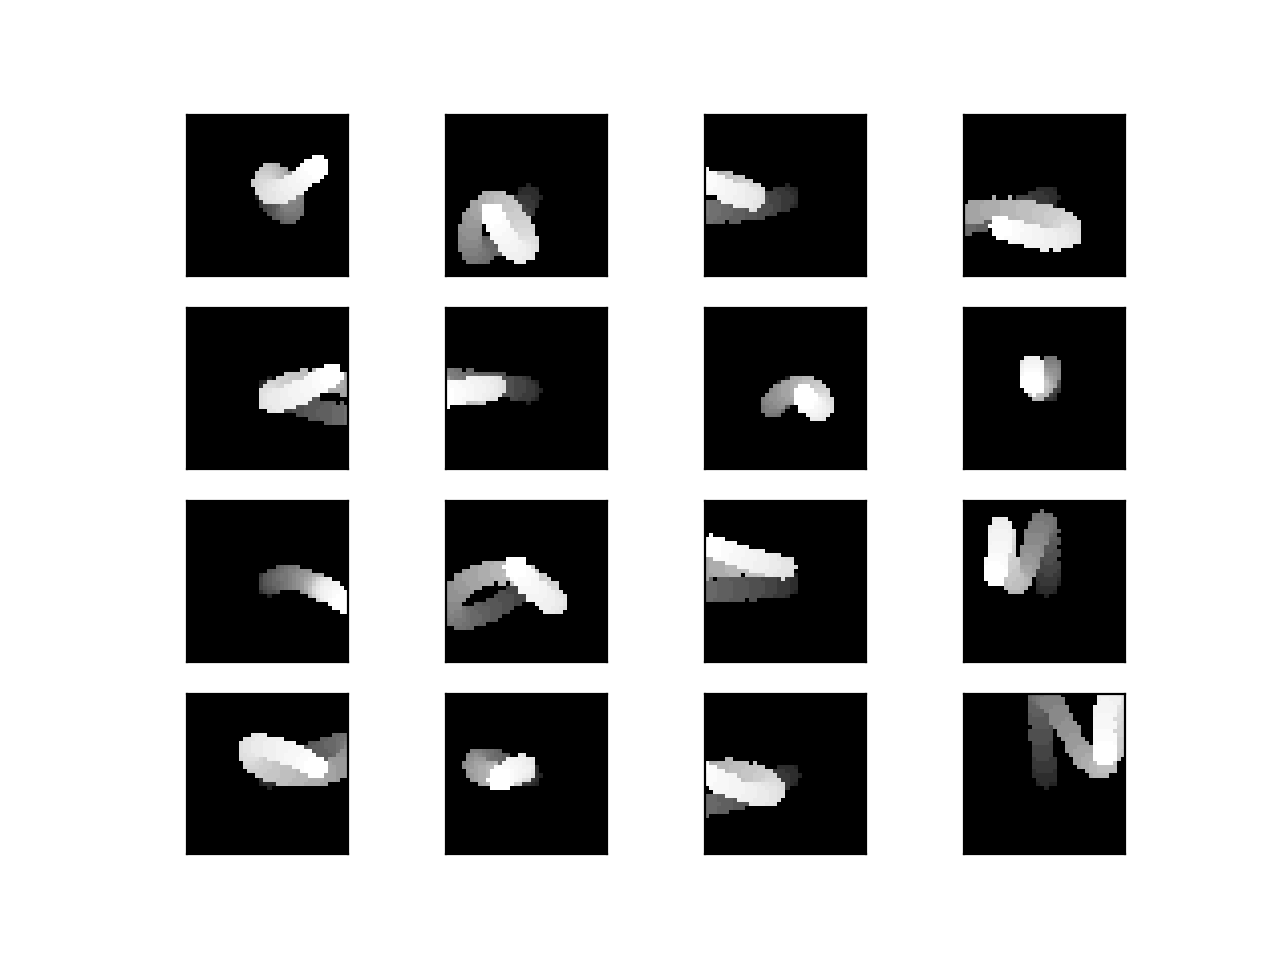

In [9]:
def make_heatmap(vid):
    vid = np.array([(t+4)*v for t,v in enumerate(vid)])
    flat_vid = np.max(vid, 0)*(1/(4+tmax))
    return flat_vid


fig, axs = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        heat_img = make_heatmap(vid_batch_normal[i+4*j,:,:,:])
        axs[i,j].imshow(1-heat_img, cmap='Greys')
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])